In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima_model import ARIMA
import itertools
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
trans_df = pd.read_csv('/Users/mehrnazuser/Documents/Lavoro/BlueRock Logistics/Data/Trans_BLR.csv', usecols = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15], sep =';', encoding = 'utf-8')
#Type_List = ['COL', 'RET']
#trans_df = trans_df.loc[trans_df['T_DOC_TYPE'].isin(Type_List)]
trans_df = trans_df.loc[trans_df['T_DOC_TYPE'] == 'COL']

trans_df['T_EFFECTIVE_DATE'] = pd.to_datetime(trans_df['T_EFFECTIVE_DATE'])
trans_df['Date'] = trans_df.apply(lambda r:r['T_EFFECTIVE_DATE'].date(), axis = 1)
trans_df = trans_df.dropna(subset = ['Date'])

trans_df = trans_df[['Date', 'T_DOC_TYPE', 'T_SENDING_ID', 'T_RTI_NAME', 'T_ACT_HAND_OUT_QTY']]
trans_df = trans_df.reset_index()
trans_df = trans_df.drop('index', axis = 1)
#trans_df.head()

In [3]:
depot_add = pd.read_excel('/Users/mehrnazuser/Documents/Lavoro/BlueRock Logistics/Data/masterdata20190918.xlsx', sheet_name = 'Depot Account_Addreses')
depot_add = depot_add[['name', 'code', 'country']]
#depot_add.head()

In [4]:
# JOIN

trans_full = trans_df.join(depot_add.set_index('code'), on = 'T_SENDING_ID')
trans_full = trans_full.drop(['T_SENDING_ID', 'T_DOC_TYPE'], axis =1)
trans_full.head()

,Date,T_RTI_NAME,T_ACT_HAND_OUT_QTY,name,country
0,2014-12-22,CC Euro Container Base,60,NL-Bleiswijk-CCNL,NL
1,2014-12-22,CC Euro Container Post 170,240,NL-Bleiswijk-CCNL,NL
2,2014-07-09,CC Container Base,4,NL-Bleiswijk Bloemenveiling Holland,NL
3,2014-07-09,CC Container Shelf,30,NL-Bleiswijk Bloemenveiling Holland,NL
4,2014-07-04,CC Container Base,4,NL-Bleiswijk Bloemenveiling Holland,NL


# Filter Dataset:

### _ONLY NL

In [5]:

trans_nl = trans_full.loc[trans_full['country'] == 'NL']
trans_nl = trans_nl.sort_values('Date', ascending = True)
trans_nl = trans_nl.drop(['country'], axis = 1)
trans_nl.head()

,Date,T_RTI_NAME,T_ACT_HAND_OUT_QTY,name
40927,2014-07-01,CBL 7,3250,NL-Zwaagdijk Vijn
2502,2014-07-01,CBL 7,3000,NL-Zwaagdijk Vijn
4766,2014-07-01,Chep blok,26,NL-Zwaagdijk Vijn
1709,2014-07-01,CBL 7,3250,NL-Zwaagdijk Vijn
1708,2014-07-01,CBL 7,3250,NL-Zwaagdijk Vijn


### _RTI = Container Base

In [6]:
nl_cb = trans_nl.loc[trans_nl['T_RTI_NAME'] == 'CC Container Base']
nl_cb = nl_cb.drop(['T_RTI_NAME'], axis = 1)
nl_cb['Date'] = pd.to_datetime(nl_cb['Date'])
nl_cb = nl_cb.set_index('Date')
nl_cb

,T_ACT_HAND_OUT_QTY,name
Date,,
2014-07-04,32,NL-Bleiswijk Bloemenveiling Holland
2014-07-04,37,NL-Bleiswijk Bloemenveiling Holland
2014-07-04,25,NL-Bleiswijk Bloemenveiling Holland
2014-07-04,4,NL-Bleiswijk Bloemenveiling Holland
2014-07-04,50,NL-Bleiswijk Bloemenveiling Holland
...,...,...
2019-07-04,30,NL-Bleiswijk Bloemenveiling Holland
2019-07-04,61,NL-Bleiswijk Bloemenveiling Holland
2019-07-05,26,NL-Hazerswoude-CCNL


Text(0.5, 1.0, 'CB_IT Jul 2014--Jul 2019')

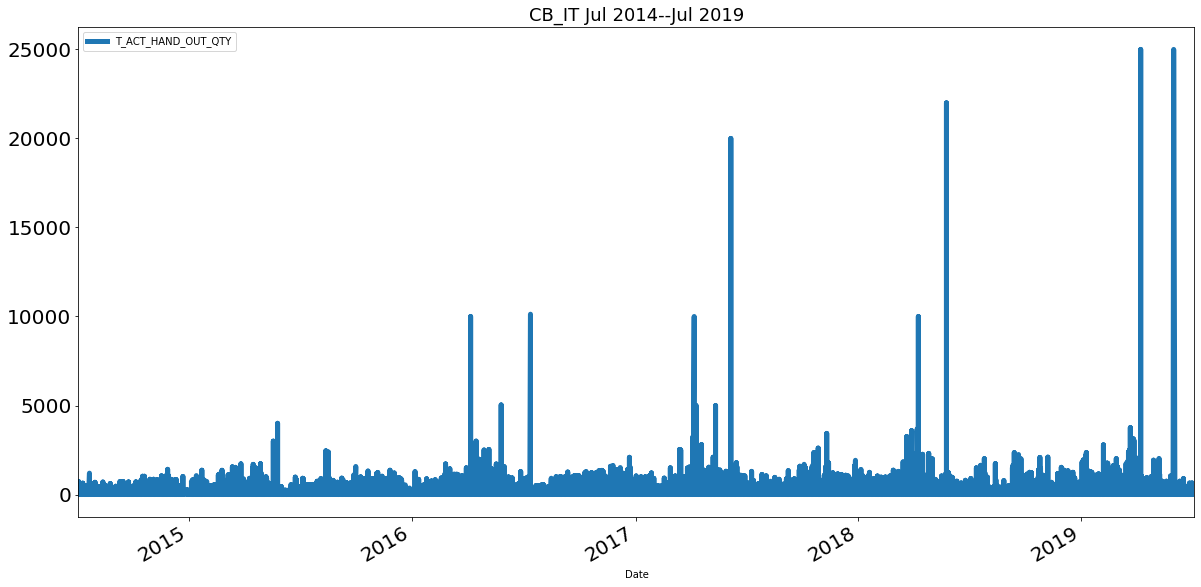

In [7]:
nl_cb.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.title("CB_IT Jul 2014--Jul 2019", fontsize = 18)

## Monthly from 2015 on

Text(0.5, 1.0, 'CB_IT : Jan 2016--Jul 2019')

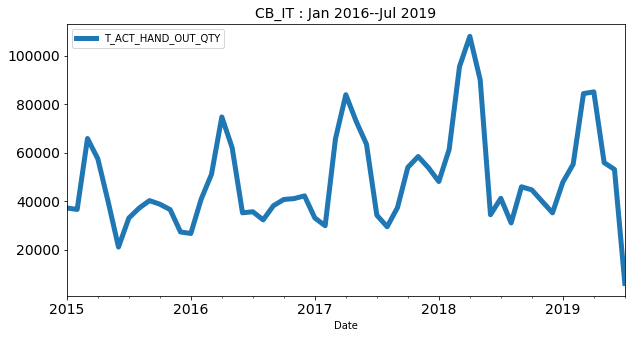

In [8]:
import datetime
nl_cbm = nl_cb.resample('1M').sum()
nl_cb_m = nl_cbm[(nl_cbm.index >= datetime.datetime(2015,1,31))]
nl_cb_m.plot(figsize=(10,5), linewidth=5, fontsize=14)
plt.title("CB_IT : Jan 2016--Jul 2019", fontsize = 14)

## Seasonal Decompose 2016

In [9]:
from statsmodels.tsa.seasonal import seasonal_decompose
from chart_studio.plotly import plot_mpl
result = seasonal_decompose(nl_cb_m, model='multiplicative')
#fig = result.plot()
#plot_mpl(fig)

Text(0.5, 1.0, 'Residual')

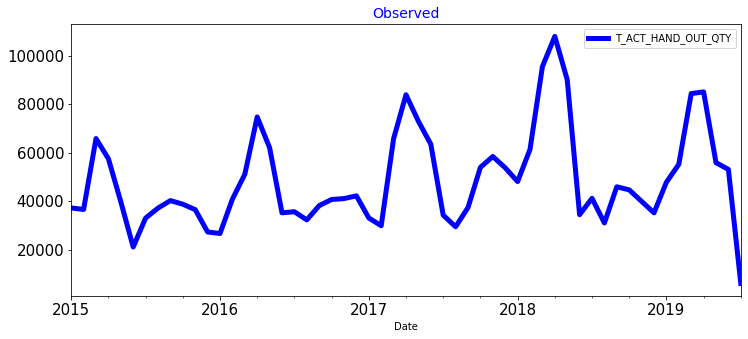

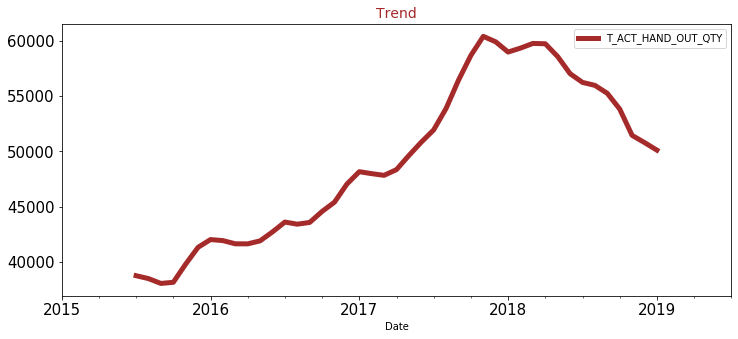

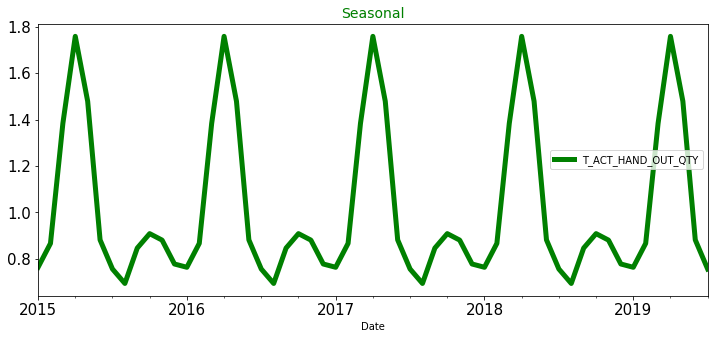

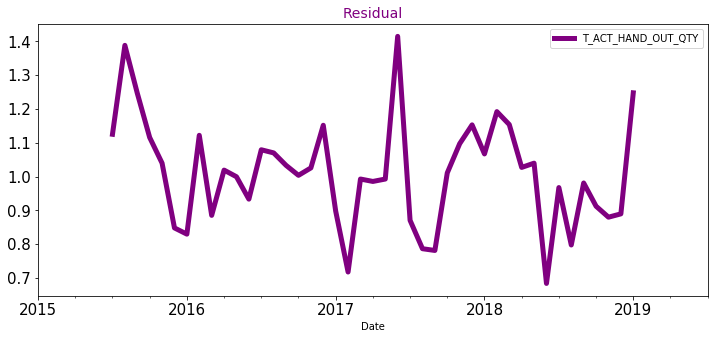

In [10]:
result.observed.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'blue')
plt.title('Observed', fontsize = 14, color ='blue')

result.trend.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'brown')
plt.title('Trend', fontsize = 14 , color = 'brown')

result.seasonal.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'green')
plt.title('Seasonal', fontsize = 14 , color = 'green')

result.resid.plot(figsize=(12,5), linewidth=5, fontsize=15, color = 'purple')
plt.title('Residual', fontsize = 14 , color = 'purple')

## SARIMA

In [11]:
#from pyramid.arima import auto_arima
import pmdarima.arima as arima
stepwise_model = arima.auto_arima(nl_cb_m, start_p=1, start_q=1,
                           max_p=6, max_q=5, m=12,
                           start_P=0, seasonal=True,
                           d=1, D=1, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(stepwise_model.aic())

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=932.547, BIC=941.235, Fit time=0.167 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=950.687, BIC=954.162, Fit time=0.009 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 12); AIC=935.305, BIC=942.255, Fit time=0.140 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 12); AIC=929.100, BIC=936.051, Fit time=0.209 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 12); AIC=948.803, BIC=950.540, Fit time=0.013 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 0, 12); AIC=936.041, BIC=941.254, Fit time=0.020 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 1, 12); AIC=931.755, BIC=940.444, Fit time=0.105 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 2, 12); AIC=nan, BIC=nan, Fit time=nan seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 0, 12); AIC=930.486, BIC=937.437, Fit time=0.122 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(1, 1, 2, 12);

In [12]:
#it_cb_m.index

In [55]:
train = nl_cb_m.loc['2014-07-04':'2019-01-04']
test = nl_cb_m.loc['2019-02-04':]

In [56]:
model_fit = stepwise_model.fit(train)
model_fit

ValueError: maxlag should be < nobs

In [19]:
future_forecast = stepwise_model.predict(n_periods=7)
future_forecast

array([18642.74903681, 28076.95322041, 30448.3508541 , 27634.44089448,
       22666.50971293, 26520.84119793, 32794.48876943])

Text(0.5, 1.0, '2019 Prediction of FR-CB')

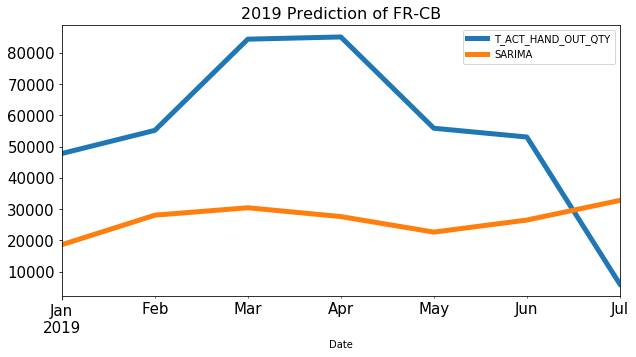

In [20]:
future_forecast = pd.DataFrame(future_forecast,index = test.index,columns=['SARIMA'])
pd.concat([test,future_forecast],axis=1).plot(figsize=(10,5), linewidth=5, fontsize=15)
plt.title('2019 Prediction of FR-CB', fontsize = 16)

In [21]:
from sklearn.metrics import mean_squared_error

mse = mean_squared_error(test, future_forecast)
mse

1471592617.7994843

In [22]:
model_fit.aic

NameError: name 'model_fit' is not defined

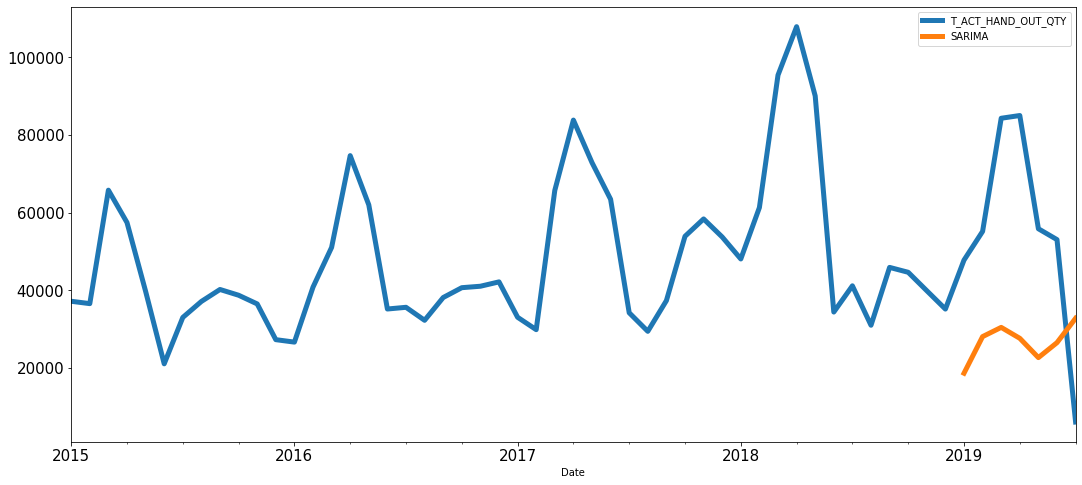

In [23]:
pd.concat([nl_cb_m,future_forecast],axis=1).plot(figsize=(18,8), linewidth=5, fontsize=15)

## ARIMA

In [24]:
#from pyramid.arima import auto_arima
import pmdarima.arima as arima
arima_model = arima.auto_arima(nl_cb_m, start_p=0, start_q=0,
                           max_p=5, max_q=5,
                           start_P=0, seasonal=False,
                           d=1, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(arima_model.aic())

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=1211.615, BIC=1215.593, Fit time=0.012 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=1211.673, BIC=1217.640, Fit time=0.013 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=1211.592, BIC=1217.559, Fit time=0.013 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 0, 0, 0); AIC=1209.684, BIC=1211.673, Fit time=0.006 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 0, 0, 0); AIC=1213.570, BIC=1221.526, Fit time=0.034 seconds
Total fit time: 0.081 seconds
1209.6835571267711


In [25]:
arima_fit = arima_model.fit(train)

In [26]:
arima_forecast = arima_fit.predict(n_periods=7)
arima_forecast

array([35170., 35170., 35170., 35170., 35170., 35170., 35170.])

Text(0.5, 1.0, '2019 Prediction of NL-CB')

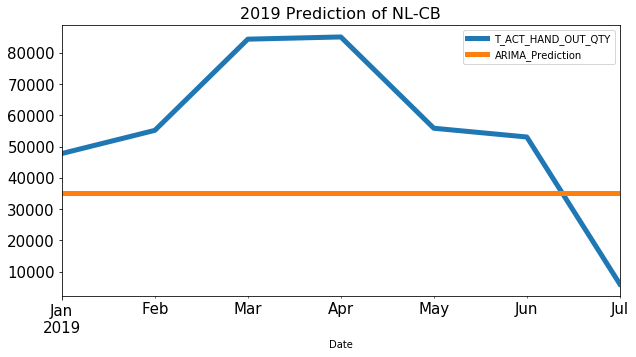

In [27]:
arima_forecast = pd.DataFrame(arima_forecast,index = test.index,columns=['ARIMA_Prediction'])
pd.concat([test,arima_forecast],axis=1).plot(figsize=(10,5), linewidth=5, fontsize=15)
plt.title('2019 Prediction of NL-CB', fontsize = 16)

Text(0.5, 1.0, '2019 (non-diff) Prediction of FR-CB')

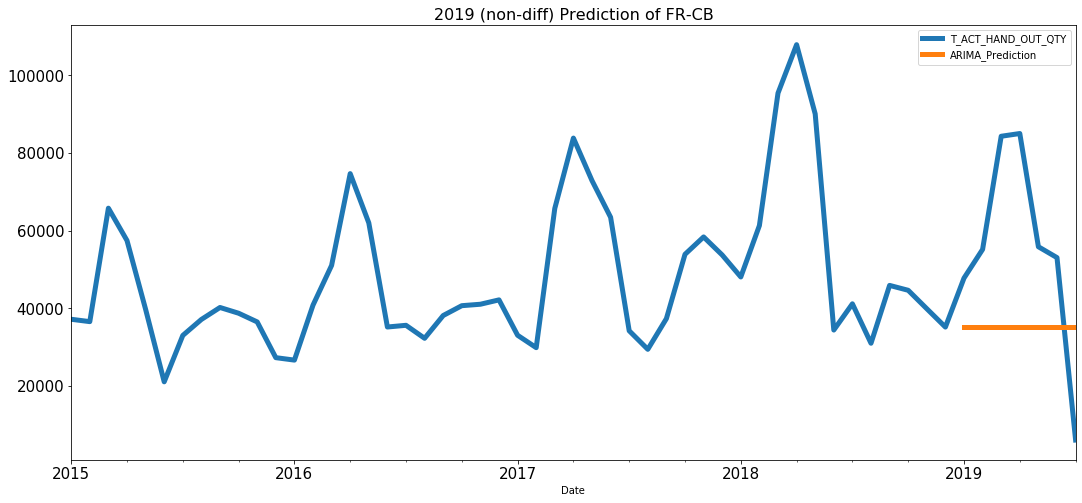

In [28]:
pd.concat([nl_cb_m, arima_forecast],axis=1).plot(figsize=(18,8), linewidth=5, fontsize=15)
plt.title('2019 (non-diff) Prediction of FR-CB', fontsize = 16)

## d&D = 0

In [29]:
#from pyramid.arima import auto_arima
import pmdarima.arima as arima
nodiff_model = arima.auto_arima(nl_cb_m, start_p=1, start_q=1,
                           max_p=3, max_q=3, m=12,
                           start_P=0, seasonal=True,
                           d=0, D=0, trace=True,
                           error_action='ignore',  
                           suppress_warnings=True, 
                           stepwise=True)
print(nodiff_model.aic())

Fit ARIMA: order=(1, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=1221.814, BIC=1231.850, Fit time=0.163 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=1248.675, BIC=1252.689, Fit time=0.006 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 0, 12); AIC=1218.736, BIC=1226.765, Fit time=0.042 seconds
Fit ARIMA: order=(0, 0, 1) seasonal_order=(0, 0, 1, 12); AIC=1225.013, BIC=1233.043, Fit time=0.065 seconds
Fit ARIMA: order=(0, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=1353.494, BIC=1355.502, Fit time=0.004 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 0, 12); AIC=1225.840, BIC=1231.862, Fit time=0.011 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(2, 0, 0, 12); AIC=1219.932, BIC=1229.968, Fit time=0.135 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(1, 0, 1, 12); AIC=1220.681, BIC=1230.717, Fit time=0.105 seconds
Fit ARIMA: order=(1, 0, 0) seasonal_order=(0, 0, 1, 12); AIC=1221.830, BIC=1229.859, Fit time=0.089 seconds
Fit ARIMA: order=(1, 0, 0) s

In [30]:
nodiff_fit = nodiff_model.fit(train)

In [31]:
nondiff_forecast = nodiff_fit.predict(n_periods=7)
nondiff_forecast

array([39620.03494877, 45894.42329145, 49649.71107128, 50241.95657306,
       49067.49600627, 47711.22799274, 46996.92042825])

Text(0.5, 1.0, '2019 Prediction of NL-CB')

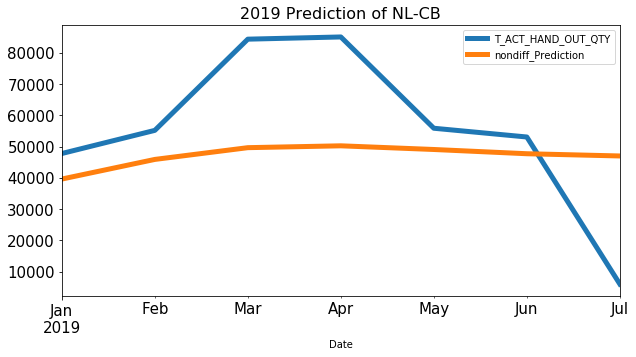

In [32]:
nondiff_forecast = pd.DataFrame(nondiff_forecast,index = test.index,columns=['nondiff_Prediction'])
pd.concat([test,nondiff_forecast],axis=1).plot(figsize=(10,5), linewidth=5, fontsize=15)
plt.title('2019 Prediction of NL-CB', fontsize = 16)

In [33]:
nondiff_mse = mean_squared_error(test, nondiff_forecast)
nondiff_mse

616498261.5467203

Text(0.5, 1.0, '2019 (non-diff) Prediction of NL-CB')

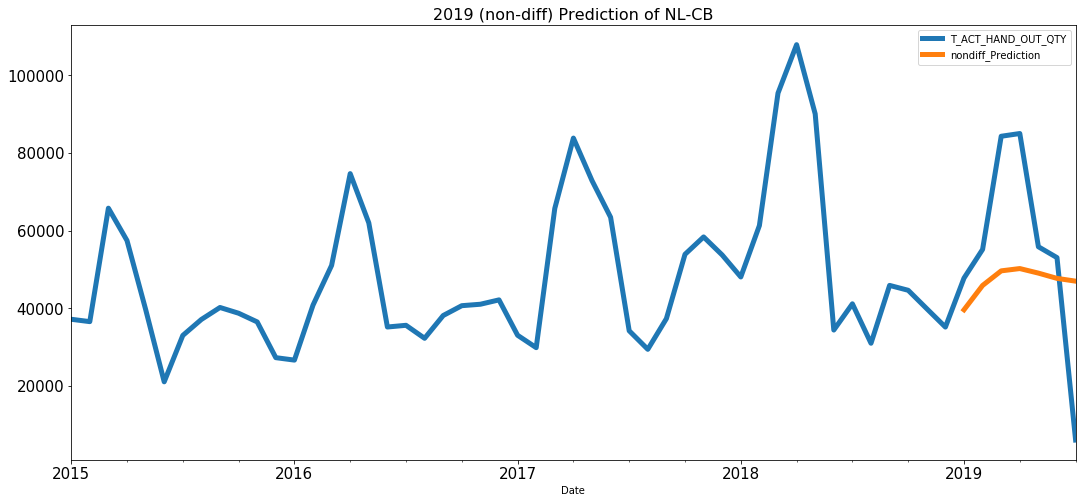

In [34]:
pd.concat([nl_cb_m,nondiff_forecast],axis=1).plot(figsize=(18,8), linewidth=5, fontsize=15)
plt.title('2019 (non-diff) Prediction of NL-CB', fontsize = 16)

## Comparison

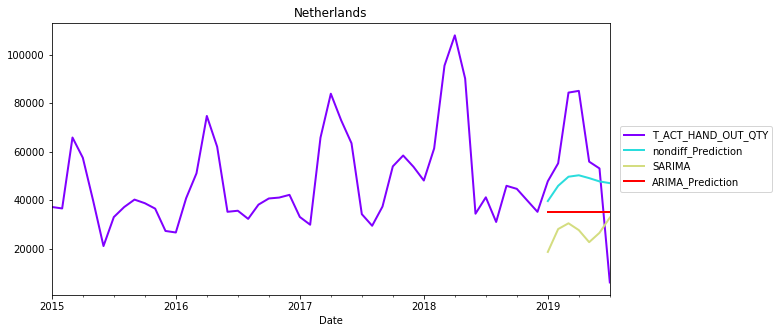

In [35]:
pd.concat([nl_cb_m, nondiff_forecast, future_forecast, arima_forecast],axis=1).plot(figsize=(10,5), colormap='rainbow', linewidth=2, title='Netherlands')
plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
plt.show()

## DEPOTS

In [36]:
trans_nl['Date'] = pd.to_datetime(trans_nl['Date'])

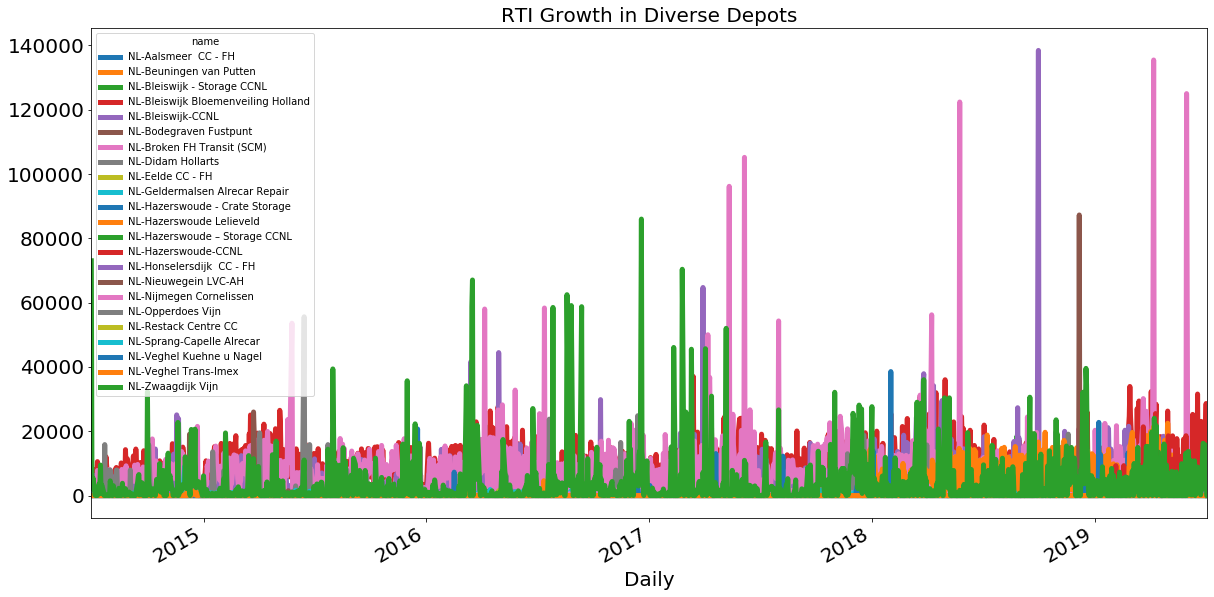

In [37]:
(trans_nl.groupby(['Date', 'name'])['T_ACT_HAND_OUT_QTY']
   .sum()
   .unstack('name', fill_value=0)
   .plot(figsize=(20,10), linewidth=5, fontsize=20))
plt.title('RTI Growth in Diverse Depots', fontsize=20)
plt.xlabel('Daily', fontsize=20)
plt.show()

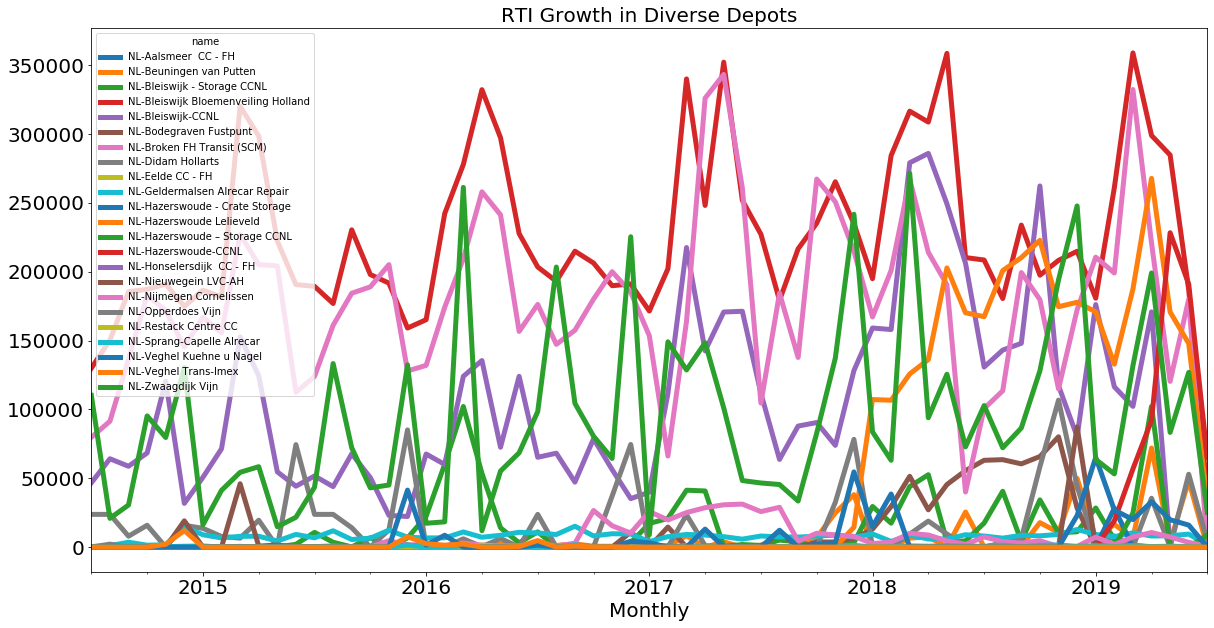

In [38]:
nl_deps = trans_nl.groupby(['Date', 'name'])['T_ACT_HAND_OUT_QTY'].sum().unstack('name', fill_value=0)
nl_deps_month = nl_deps.resample('1M').sum()
nl_deps_month.plot(figsize=(20,10), linewidth=5, fontsize=20)
plt.title('RTI Growth in Diverse Depots', fontsize=20)
plt.xlabel('Monthly', fontsize=20)
plt.show()

In [39]:
depos = trans_nl['name'].unique()

In [40]:
def optimal_sarima(depot):
    
    stepwise_model = arima.auto_arima(depot, start_p=1, start_q=1,
                               max_p=3, max_q=3, m=6,
                               start_P=0, seasonal=True,
                               d=1, D=1, trace=True,
                               error_action='ignore',  
                               suppress_warnings=True, 
                               stepwise=True)
    return stepwise_model
    #print(stepwise_model.aic())

In [43]:
opt_sarima_deps = []
for i in range(0,len(depos)):
    dep = nl_deps[[depos[i]]].dropna()
    print('\n ' + depos[i] + ': ')
    print('\n')
    opt_sarima = optimal_sarima(dep)
    print(opt_sarima.aic())
    opt_sarima_deps.append(opt_sarima)


 NL-Zwaagdijk Vijn: 


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=29646.985, BIC=29673.308, Fit time=4.008 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=31384.087, BIC=31394.616, Fit time=0.049 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 6); AIC=30669.875, BIC=30690.933, Fit time=0.327 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=29642.317, BIC=29663.376, Fit time=1.968 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=31382.117, BIC=31387.382, Fit time=0.042 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 6); AIC=30491.483, BIC=30512.542, Fit time=0.988 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit AR

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 6); AIC=29272.629, BIC=29293.688, Fit time=0.911 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 6); AIC=28782.494, BIC=28814.082, Fit time=3.908 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 6); AIC=28909.569, BIC=28941.157, Fit time=4.098 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 2, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.995)
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 6); AIC=28976.649, BIC=29002.972, Fit time=2.650 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 0, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 6); AIC=28895.541, BIC=28932.394, Fit 

Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 6); AIC=29468.520, BIC=29494.844, Fit time=2.799 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 0, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 2, 6); AIC=29157.578, BIC=29194.432, Fit time=6.419 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 2, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 6); AIC=29510.040, BIC=29531.099, Fit time=1.590 seconds
Near non-invertible roots for order (1, 1, 0)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=29185.253, BIC=29216.842, Fit time=4.766 seconds
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 1, 6); AIC=29360.120, BIC=29391.708, Fit 

Fit ARIMA: order=(1, 1, 0) seasonal_order=(0, 1, 1, 6); AIC=12797.684, BIC=12818.743, Fit time=0.753 seconds
Near non-invertible roots for order (1, 1, 0)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(2, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=12218.095, BIC=12249.683, Fit time=3.166 seconds
Near non-invertible roots for order (2, 1, 1)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 1, 6); AIC=12218.014, BIC=12249.603, Fit time=2.704 seconds
Near non-invertible roots for order (1, 1, 2)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 6); AIC=13204.441, BIC=13220.236, Fit time=1.046 seconds
Near non-invertible roots for order (0, 1, 0)(0, 1, 1, 6); setting score to inf (at least 

Fit ARIMA: order=(1, 1, 2) seasonal_order=(0, 1, 1, 6); AIC=16268.129, BIC=16299.717, Fit time=2.196 seconds
Near non-invertible roots for order (1, 1, 2)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 6); AIC=17244.933, BIC=17260.727, Fit time=0.570 seconds
Near non-invertible roots for order (0, 1, 0)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 1, 6); AIC=16266.094, BIC=16292.418, Fit time=1.673 seconds
Near non-invertible roots for order (0, 1, 2)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 1, 6); AIC=16667.433, BIC=16693.757, Fit time=1.023 seconds
Near non-invertible roots for order (2, 1, 0)(0, 1, 1, 6); setting score to inf (at least 

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 1, 6); AIC=5387.037, BIC=5402.831, Fit time=1.188 seconds
Near non-invertible roots for order (0, 1, 0)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 1, 6); AIC=4425.841, BIC=4452.165, Fit time=2.192 seconds
Near non-invertible roots for order (0, 1, 2)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.997)
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 1, 6); AIC=4809.135, BIC=4835.459, Fit time=2.479 seconds
Near non-invertible roots for order (2, 1, 0)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 1, 6); AIC=4409.339, BIC=4446.192, Fit time=4.722 seconds
Near non-invertible roots for order (2, 1, 2)(0, 1, 1, 6); setting score to inf (at least one inve

Fit ARIMA: order=(0, 1, 2) seasonal_order=(0, 1, 1, 6); AIC=26475.009, BIC=26501.333, Fit time=3.114 seconds
Near non-invertible roots for order (0, 1, 2)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 1, 6); AIC=26862.080, BIC=26888.404, Fit time=1.683 seconds
Near non-invertible roots for order (2, 1, 0)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 1, 6); AIC=26781.727, BIC=26818.580, Fit time=4.007 seconds
Near non-invertible roots for order (2, 1, 2)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 47.308 seconds
26475.008867613455

 NL-Bleiswijk - Storage CCNL: 


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=25640.087, BIC=25666.410, Fit time=4.224 seconds
Fit AR

Fit ARIMA: order=(2, 1, 0) seasonal_order=(0, 1, 1, 6); AIC=22622.747, BIC=22649.070, Fit time=1.453 seconds
Near non-invertible roots for order (2, 1, 0)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 1, 6); AIC=22745.750, BIC=22782.603, Fit time=1.731 seconds
Near non-invertible roots for order (2, 1, 2)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 38.918 seconds
22369.389287291342

 NL-Beuningen van Putten: 


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=23984.681, BIC=24011.005, Fit time=3.846 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=25297.195, BIC=25307.724, Fit time=0.047 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 6); AIC=24709.173, BIC=24730.232, Fit time=0.977 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 6); AIC

Fit ARIMA: order=(2, 1, 2) seasonal_order=(0, 1, 1, 6); AIC=25326.751, BIC=25363.604, Fit time=4.307 seconds
Near non-invertible roots for order (2, 1, 2)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Total fit time: 44.993 seconds
25273.182650421288

 NL-Restack Centre CC: 


Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=14636.491, BIC=14662.814, Fit time=1.883 seconds
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=16569.736, BIC=16580.266, Fit time=0.044 seconds
Fit ARIMA: order=(1, 1, 0) seasonal_order=(1, 1, 0, 6); AIC=15753.520, BIC=15774.579, Fit time=0.534 seconds
Fit ARIMA: order=(0, 1, 1) seasonal_order=(0, 1, 1, 6); AIC=14634.754, BIC=14655.813, Fit time=3.066 seconds
Near non-invertible roots for order (0, 1, 1)(0, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=16

Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 6); AIC=27198.593, BIC=27219.652, Fit time=1.704 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 6); AIC=26694.748, BIC=26726.336, Fit time=4.715 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 0.992)
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 6); AIC=26720.248, BIC=26751.837, Fit time=6.743 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 2, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 6); AIC=26978.592, BIC=27004.916, Fit time=2.635 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 0, 6); setting score to inf (at least 

Fit ARIMA: order=(0, 1, 0) seasonal_order=(0, 1, 0, 6); AIC=22182.224, BIC=22187.489, Fit time=0.440 seconds
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 0, 6); AIC=21634.537, BIC=21655.596, Fit time=2.834 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 0, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 1, 6); AIC=21000.221, BIC=21031.809, Fit time=11.296 seconds
Near non-invertible roots for order (1, 1, 1)(1, 1, 1, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(1, 1, 1) seasonal_order=(0, 1, 2, 6); AIC=20990.189, BIC=21021.777, Fit time=18.593 seconds
Near non-invertible roots for order (1, 1, 1)(0, 1, 2, 6); setting score to inf (at least one inverse root too close to the border of the unit circle: 1.000)
Fit ARIMA: order=(1, 1, 1) seasonal_order=(1, 1, 0, 6); AIC=21472.248, BIC=21498.571, Fi

In [42]:
opt_sarima_deps[0]

IndexError: list index out of range

In [44]:
d1 = nl_cb2015[[depos[0]]].dropna()
train1 = d1.loc['2015-01-31':'2018-12-31']
test1 = d1.loc['2019-01-31':]


NameError: name 'nl_cb2015' is not defined

In [ ]:
dep1_fit = opt_sarima_deps[0].fit(train1)

In [ ]:
dep1_forecast = dep1_fit.predict(n_periods=7)
dep1_forecast

In [ ]:
dep1_forecast = pd.DataFrame(dep1_forecast,index = test.index,columns=[depos[0] + '_Prediction'])
pd.concat([test1,dep1_forecast],axis=1).plot(figsize=(10,5), linewidth=5, fontsize=14)
plt.title('2019 Prediction of ' + depos[1], fontsize = 14)

In [ ]:
for j in range(0,len(depos)):
    d = nl_cb2015[[depos[i]]].dropna()
    

    print(d.index)

In [ ]:
optimal_test = list()
optimal_prediction = list()
opt_deps_forecast = list()
depo_train = list()
depo_test = list()
mse = list()

for f in range(0, len(depos)):
    dep = nl_cb2015[[depos[f]]].dropna()
    my_train = dep.loc['2015-01-31':'2018-12-31']
    my_test = dep.loc['2019-01-31':]
    
    model_fit = opt_sarima_deps[f].fit(my_train)

    depo_forecast = model_fit.predict(n_periods=7)
    
    for col in range(len(depo_forecast)):
        if depo_forecast[col] < 0:
            depo_forecast[col] = 0
    
    opt_deps_forecast.append(depo_forecast)
    depo_train.append(my_train)
    depo_test.append(my_test)
    



In [ ]:
depo_test

In [ ]:
opt_deps_forecast

In [ ]:
depots_forecasts = pd.DataFrame()

In [ ]:
for i in range(0, len(depos)):
    depots_forecasts[depos[i]] = opt_deps_forecast[i]
    

In [ ]:
my_test

In [ ]:
depots_forecasts['Date'] = my_test.index
depots_forecasts = depots_forecasts.set_index('Date')
depots_forecasts

In [ ]:
def plot_depo_prediction(depo_name, depo_test, depo_pred):
        pd.concat([depo_test, depo_pred], axis=1).plot(figsize=(10,5), linewidth=5, fontsize=14)
        plt.title('2019 Prediction of ' + depo_name, fontsize = 14)        

In [ ]:
depos_mse = list()
for j in range(0, len(depos)):
    plot_depo_prediction(depos[j], depo_test[j], depots_forecasts[[depos[j]]])
    mse = mean_squared_error(depo_test[j], depots_forecasts[[depos[j]]])
    depos_mse.append(mse)

In [ ]:
depos_mse

In [ ]:
norm = [i/sum(depos_mse) for i in depos_mse]
norm

In [ ]:
print('Normalized MSE of depots: ')
for r in range(0, len(depos)):
    print('\n ' + depos[r] + ' : ' + str(norm[r]))

i = norm.index(min(norm))
print('\n the MOST accurate : ' + depos[i])

j = norm.index(max(norm))
print('\n the LEAST accurate: ' + depos[j])

In [ ]:
for s in range(0, len(depos)):
    pd.concat([fr_cb2016[[depos[s]]], depots_forecasts[[depos[s]]]],axis=1).plot(figsize=(18,8), linewidth=5, fontsize=15)

### Summation is NOT a good idea for France:

In [ ]:
depots_forecasts['france'] = depots_forecasts.sum(axis=1)
#depots_forecasts

In [ ]:
pd.concat([it_cb_m, depots_forecasts['france'], future_forecast],axis=1).plot(figsize=(10,5), colormap='rainbow', linewidth=2, title='France prediction')

In [ ]:
#pd.concat([it_cb_m, depots_forecasts['france'], future_forecast],axis=1).plot(figsize=(10,5), colormap='rainbow', linewidth=2, title='France prediction')
pd.concat([it_cb_m, future_forecast],axis=1).plot(figsize=(10,5), colormap='rainbow', linewidth=2, title='France prediction')
plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
plt.show()

In [ ]:
#future_forecast

In [ ]:
for col in future_forecast:
    future_forecast[col][future_forecast[col] < 0] = 0

In [ ]:
#future_forecast

In [ ]:
pd.concat([it_cb_m, future_forecast],axis=1).plot(figsize=(10,5), colormap='rainbow', linewidth=2, title='France prediction')
plt.legend(loc='right', bbox_to_anchor=(1.3, 0.5))
plt.show()

In [ ]:
depots_forecasts = depots_forecasts.drop('france', axis = 1)

In [ ]:
depots_forecasts['total'] = future_forecast

In [ ]:
depots_forecasts

In [ ]:
depots_forecasts['sum(ExceptLyon)'] = depots_forecasts.drop('F-26 Lyon HortiTrace', axis=1).sum(axis=1)
depots_forecasts

In [ ]:
depots_forecasts['Lyon_reprediction'] = depots_forecasts['total'] - depots_forecasts['sum(ExceptLyon)']

In [ ]:
pd.concat([fr_cb2016[[depos[0]]], depots_forecasts['Lyon_reprediction']],axis=1).plot(figsize=(18,8), linewidth=5, fontsize=15)